In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn.model_selection

### Utility functions

In [2]:
def do_pred_and_eval(w, b, x_test, y_test):
  p = 1 / (1 + np.exp(-1*(w.T @ x_test.T + b)))
  y_test_pred = np.zeros(p.shape)
  y_test_pred[p >= 0.5] = 1
  err = np.sum(y_test_pred.T != y_test)
  return err

def compute_gradient(x_transpose, y, w, b, l2_reg):
  tmp_exp = np.exp(w.T @ x_transpose + b)
  tmp_frac = 1 / (1 + tmp_exp) * tmp_exp

  grad_w = - y.T * x_transpose
  grad_w += tmp_frac * x_transpose
  grad_w = np.sum(grad_w, axis=1, keepdims=True) + l2_reg * w 
  grad_b = np.sum(-y.T + tmp_frac, axis=1, keepdims=True)
  return grad_w, grad_b
  
def compute_loss(x_transpose, y, w, b, l2_reg):
  tmp_prod = w.T @ x_transpose + b
  loss = -y.T * tmp_prod + np.log(1+np.exp(tmp_prod)) + (l2_reg / 2) * np.power(np.linalg.norm(w), 2)
  return np.sum(loss)

def compute_convergence(x_transpose, y, w, b, l2_reg):
  grad_w, grad_b = compute_gradient(x_transpose, y_train, w, b, l2_reg)
  num = np.power(np.linalg.norm(np.vstack((grad_w, grad_b))), 2)
  den = (1 + np.abs(compute_loss(x_transpose, y, w, b, l2_reg)))
  return num / den

### Load data

In [3]:
data = np.genfromtxt('wdbc.data', delimiter=',')
labels = data[:, 1:2]
features = data[:, 2:]

In [4]:
print(labels.shape)
print(features.shape)

(569, 1)
(569, 30)


### Normalize the data

In [5]:
features_norm = features - np.mean(features, axis=0, keepdims=True)
features_norm /= np.linalg.norm(features_norm, axis=0, keepdims=True)

### Partition data

In [6]:
_NUM_EXPERIMENTS = 100

all_splits = []
for _ in range(_NUM_EXPERIMENTS):
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features_norm, labels, train_size=500, test_size=69)
  all_splits.append({'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test})

### Normal gradient descent

In [7]:
_L2_REG = 0.01
_NUM_ITER = 500
_LR = 1e-2

test_err, convergence_gd = [], np.zeros((_NUM_EXPERIMENTS, _NUM_ITER))
for exp_cnt in range(_NUM_EXPERIMENTS):
  this_split = all_splits[exp_cnt]
  x_train, x_test = this_split['x_train'], this_split['x_test'] # (time, features)
  y_train, y_test = this_split['y_train'], this_split['y_test'] # (time, 1)

  w, b = np.zeros((x_train.shape[1], 1)), 0 # Initialize.
  x_train_tranpose = x_train.T # (features, time)
  for this_iter in range(_NUM_ITER):
    grad_w, grad_b = compute_gradient(x_train_tranpose, y_train, w, b, _L2_REG)
    w -= _LR * grad_w
    b -= _LR * grad_b[0]
  
    conv = compute_convergence(x_train_tranpose, y_train, w, b, _L2_REG)
    convergence_gd[exp_cnt, this_iter] = conv
    
#     if this_iter % 100 == 0:
#       err = do_pred_and_eval(w, b, x_test, y_test)
#       print(f'prediction error for iter:{this_iter} is {err}')
    
  # Compute error
  err = do_pred_and_eval(w, b, x_test, y_test)
#   print(f'prediction error for experiment:{exp_cnt} is {err}')
  test_err.append(err)

In [8]:
ave_err = np.mean(test_err)
ttl_test = np.size(y_test)
print(f'Average error over {_NUM_EXPERIMENTS} experiments is {ave_err} out of {ttl_test} [{np.around(ave_err/ttl_test*100, 2)}%]')

Average error over 100 experiments is 2.64 out of 69 [3.83%]


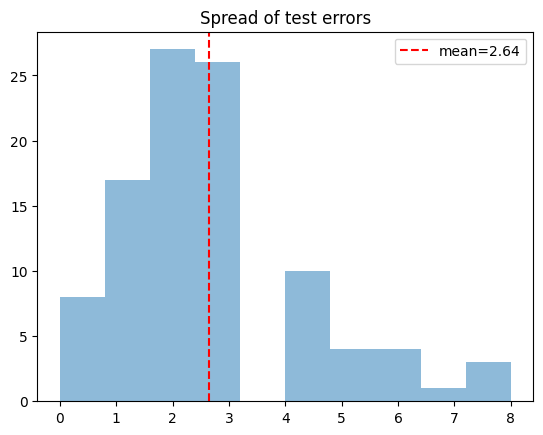

In [9]:
plt.hist(test_err, alpha=0.5)
plt.title('Spread of test errors')
plt.axvline(ave_err, color='r', linestyle='--', label=f'mean={ave_err}')
plt.legend()
plt.show()

#### Iterations experiment

In [10]:
_L2_REG = 0.01
_LR = 1e-2
_CONV_RATIO = 1e-6

test_err, iter_cnt_list, convergence_gd_final = [], [], []
for exp_cnt in range(_NUM_EXPERIMENTS):
  this_split = all_splits[exp_cnt]
  x_train, x_test = this_split['x_train'], this_split['x_test'] # (time, features)
  y_train, y_test = this_split['y_train'], this_split['y_test'] # (time, 1)

  w, b = np.zeros((x_train.shape[1], 1)), 0 # Initialize.
  x_train_tranpose = x_train.T # (features, time)
  conv = compute_convergence(x_train_tranpose, y_train, w, b, _L2_REG)
  iter_cnt, this_convergence_gd = 0, []
  while conv > _CONV_RATIO:
    iter_cnt += 1
    grad_w, grad_b = compute_gradient(x_train_tranpose, y_train, w, b, _L2_REG)
    w -= _LR * grad_w
    b -= _LR * grad_b[0]
    
    conv = compute_convergence(x_train_tranpose, y_train, w, b, _L2_REG)
    this_convergence_gd.append(conv)
    
  # Compute error
  err = do_pred_and_eval(w, b, x_test, y_test)
#   print(f'prediction error for experiment:{exp_cnt} is {err}')
  test_err.append(err)
  iter_cnt_list.append(iter_cnt)
  convergence_gd_final.append(this_convergence_gd)

In [11]:
# np.savez(os.path.join(os.getcwd(), 'sg_results_1e-2LR'),
#          iter_cnt_list = iter_cnt_list, convergence_gd_final=convergence_gd_final, test_err=test_err)

In [12]:
ave_err = np.mean(test_err)
ttl_test = np.size(y_test)
ave_iter = np.mean(iter_cnt_list)
print(f'Took on average {ave_iter} iterations (over {_NUM_EXPERIMENTS} experiments) to converge to {_CONV_RATIO}')
print(f'Average error over {_NUM_EXPERIMENTS} experiments is {ave_err} out of {ttl_test} [{np.around(ave_err/ttl_test*100, 2)}%]')


Took on average 8123.09 iterations (over 100 experiments) to converge to 1e-06
Average error over 100 experiments is 1.56 out of 69 [2.26%]


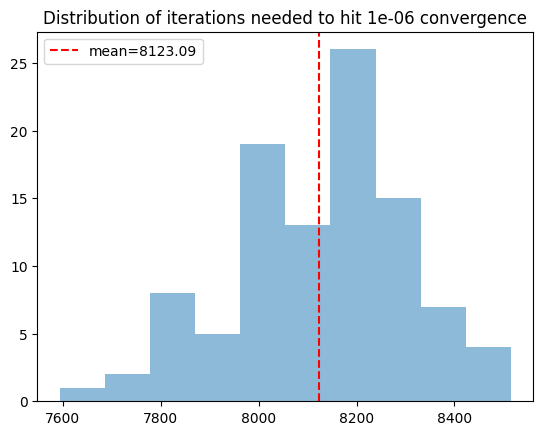

In [13]:
plt.hist(iter_cnt_list, alpha=0.5)
plt.axvline(ave_iter, color='r', linestyle='--', label=f'mean={ave_iter}')
plt.legend()
plt.title(f'Distribution of iterations needed to hit {_CONV_RATIO} convergence')
plt.show()

### Adding momentum

#### Heavyball

In [14]:
## Heavy Ball
_L2_REG = 0.01
_LR = 1e-2
_CONV_RATIO = 1e-6
_MOMENTUM = 0.98

test_err_heavyball, iter_cnt_list_heavyball, convergence_heavyball = [], [], []
for exp_cnt in range(_NUM_EXPERIMENTS):
  this_split = all_splits[exp_cnt]
  x_train, x_test = this_split['x_train'], this_split['x_test'] # (time, features)
  y_train, y_test = this_split['y_train'], this_split['y_test'] # (time, 1)

  w, b = np.zeros((x_train.shape[1], 1)), 0 # Initialize.
  momentum_buffer_w, momentum_buffer_b = np.zeros(w.shape), 0
  x_train_tranpose = x_train.T # (features, time)
  conv = compute_convergence(x_train_tranpose, y_train, w, b, _L2_REG)
  iter_cnt, this_convergence_heavyball = 0, []
  while conv > _CONV_RATIO:
    iter_cnt += 1
    grad_w, grad_b = compute_gradient(x_train_tranpose, y_train, w, b, _L2_REG)
    momentum_buffer_w = -_LR * grad_w + _MOMENTUM * momentum_buffer_w
    w += momentum_buffer_w
    momentum_buffer_b = -_LR * grad_b[0] + _MOMENTUM * momentum_buffer_b
    b += momentum_buffer_b
    
    conv = compute_convergence(x_train_tranpose, y_train, w, b, _L2_REG)
    this_convergence_heavyball.append(conv)
  
#     if iter_cnt % 1000 == 0:
#       err = do_pred_and_eval(w, b, x_test, y_test)
#       print(f'prediction error for iter:{iter_cnt} is {err}')
    
  # Compute error
  err = do_pred_and_eval(w, b, x_test, y_test)
#   print(f'prediction error for experiment:{exp_cnt} after {iter_cnt} iterations is: {err}')
  test_err_heavyball.append(err)
  iter_cnt_list_heavyball.append(iter_cnt)
  convergence_heavyball.append(this_convergence_heavyball)

In [15]:
# np.savez(os.path.join(os.getcwd(), 'heavyball_results_1e-2LR'),
#          iter_cnt_list_heavyball = iter_cnt_list_heavyball,
#          convergence_heavyball = convergence_heavyball,
#          test_err_heavyball = test_err_heavyball)

In [16]:
ave_err = np.mean(test_err_heavyball)
ttl_test = np.size(y_test)
ave_iter = np.mean(iter_cnt_list_heavyball)
print(f'Took on average {ave_iter} iterations (over {_NUM_EXPERIMENTS} experiments) to converge to {_CONV_RATIO}')
print(f'Average error over {_NUM_EXPERIMENTS} experiments is {ave_err} out of {ttl_test} [{np.around(ave_err/ttl_test*100, 2)}%]')


Took on average 427.87 iterations (over 100 experiments) to converge to 1e-06
Average error over 100 experiments is 1.53 out of 69 [2.22%]


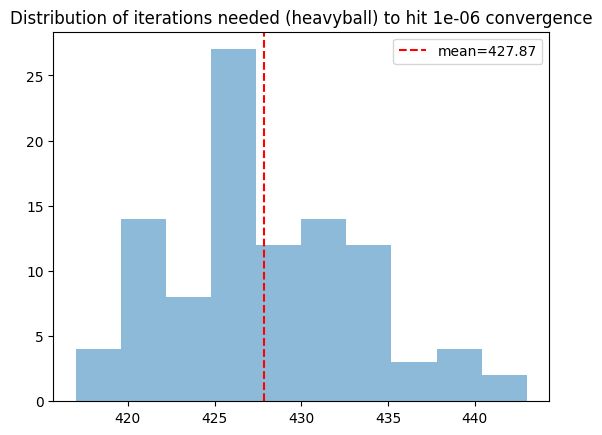

In [17]:
plt.hist(iter_cnt_list_heavyball, alpha=0.5)
plt.axvline(ave_iter, color='r', linestyle='--', label=f'mean={ave_iter}')
plt.legend()
plt.title(f'Distribution of iterations needed (heavyball) to hit {_CONV_RATIO} convergence')
plt.show()

#### Nesterov

In [18]:
## Nesterov
_L2_REG = 0.01
_LR = 1e-2
_CONV_RATIO = 1e-6
_MOMENTUM = 0.98

test_err_nesterov, iter_cnt_list_nesterov, convergence_nesterov = [], [], []
for exp_cnt in range(_NUM_EXPERIMENTS):
  this_split = all_splits[exp_cnt]
  x_train, x_test = this_split['x_train'], this_split['x_test'] # (time, features)
  y_train, y_test = this_split['y_train'], this_split['y_test'] # (time, 1)

  w, b = np.zeros((x_train.shape[1], 1)), 0 # Initialize.
  momentum_buffer_w, momentum_buffer_b = np.zeros(w.shape), 0
  x_train_tranpose = x_train.T # (features, time)
  conv = compute_convergence(x_train_tranpose, y_train, w, b, _L2_REG)
  iter_cnt, this_convergence_nesterov = 0, []
  while conv > _CONV_RATIO:
    iter_cnt += 1
    nesterov_step_w = w + momentum_buffer_w * _MOMENTUM
    nesterov_step_b = b + momentum_buffer_b * _MOMENTUM
    grad_w, grad_b = compute_gradient(x_train_tranpose, y_train, nesterov_step_w, nesterov_step_b, _L2_REG)
    momentum_buffer_w = -_LR * grad_w + _MOMENTUM * momentum_buffer_w
    w += momentum_buffer_w
    momentum_buffer_b = -_LR * grad_b[0] + _MOMENTUM * momentum_buffer_b
    b += momentum_buffer_b
    
    conv = compute_convergence(x_train_tranpose, y_train, w, b, _L2_REG)
    this_convergence_nesterov.append(conv)
  
#     if iter_cnt % 1000 == 0:
#       err = do_pred_and_eval(w, b, x_test, y_test)
#       print(f'prediction error for iter:{iter_cnt} is {err}')
    
  # Compute error
  err = do_pred_and_eval(w, b, x_test, y_test)
#   print(f'prediction error for experiment:{exp_cnt} after {iter_cnt} iterations is {err}')
  test_err_nesterov.append(err)
  iter_cnt_list_nesterov.append(iter_cnt)
  convergence_nesterov.append(this_convergence_nesterov)

In [19]:
# np.savez(os.path.join(os.getcwd(), 'nesterov_results_1e-2LR'),
#          iter_cnt_list_nesterov = iter_cnt_list_nesterov,
#          convergence_nesterov = convergence_nesterov,
#          test_err_nesterov = test_err_nesterov)

In [20]:
ave_err = np.mean(test_err_nesterov)
ttl_test = np.size(y_test)
ave_iter = np.mean(iter_cnt_list_nesterov)
print(f'Took on average {ave_iter} iterations (over {_NUM_EXPERIMENTS} experiments) to converge to {_CONV_RATIO}')
print(f'Average error over {_NUM_EXPERIMENTS} experiments is {ave_err} out of {ttl_test} [{np.around(ave_err/ttl_test*100, 2)}%]')


Took on average 402.53 iterations (over 100 experiments) to converge to 1e-06
Average error over 100 experiments is 1.53 out of 69 [2.22%]


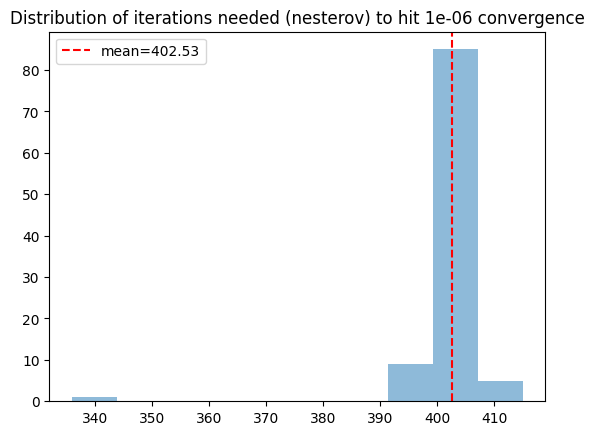

In [21]:
plt.hist(iter_cnt_list_nesterov, alpha=0.5)
plt.axvline(ave_iter, color='r', linestyle='--', label=f'mean={ave_iter}')
plt.legend()
plt.title(f'Distribution of iterations needed (nesterov) to hit {_CONV_RATIO} convergence')
plt.show()

### Figures

In [22]:
_NUM_TO_VIZ = _NUM_ITER
nesterov_convergence = np.ones((_NUM_EXPERIMENTS, _NUM_TO_VIZ)) * _CONV_RATIO
heavyball_convergence = np.ones((_NUM_EXPERIMENTS, _NUM_TO_VIZ)) * _CONV_RATIO
gd_convergence = np.ones((_NUM_EXPERIMENTS, _NUM_TO_VIZ)) * _CONV_RATIO

for exp_cnt in range(_NUM_EXPERIMENTS):
  nesterov_convergence[exp_cnt, :len(convergence_nesterov[exp_cnt])] = convergence_nesterov[exp_cnt][:_NUM_ITER]
  heavyball_convergence[exp_cnt, :len(convergence_heavyball[exp_cnt])] = convergence_heavyball[exp_cnt][:_NUM_ITER]
  gd_convergence[exp_cnt, :len(convergence_gd_final[exp_cnt])] = convergence_gd_final[exp_cnt][:_NUM_ITER]

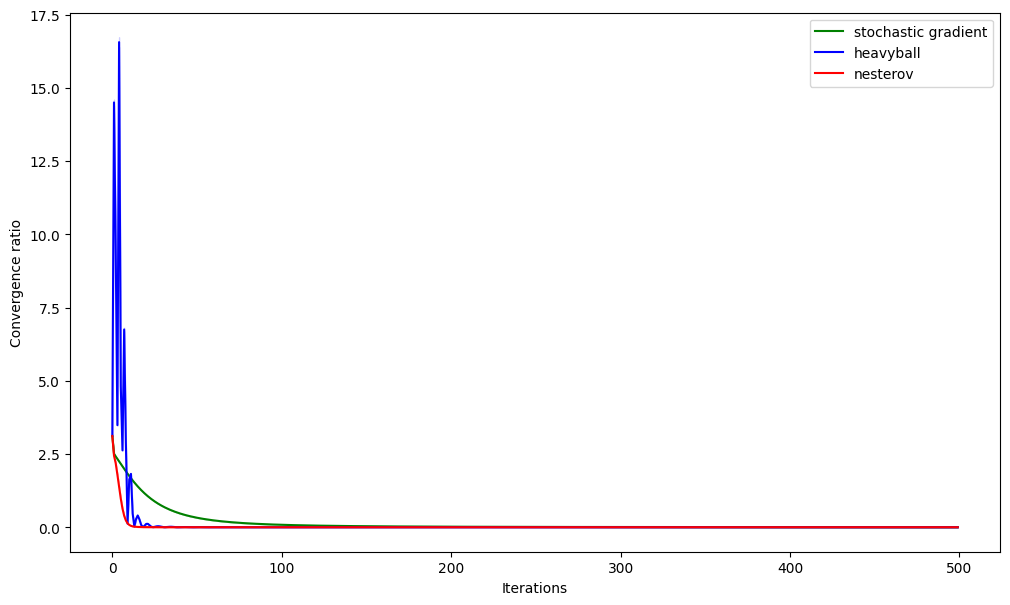

In [23]:
x_ax = np.arange(_NUM_ITER)

fig, ax = plt.subplots(figsize=(12, 7))

gd_mean = gd_convergence.mean(0)
gd_stderr = gd_convergence.std(0) / np.sqrt(_NUM_EXPERIMENTS)
ax.plot(x_ax, gd_mean, '-', c='g', label='stochastic gradient')
ax.fill_between(x_ax, gd_mean - gd_stderr, gd_mean + gd_stderr, alpha=0.2, color='g')

heavyball_mean = heavyball_convergence.mean(0)
heavyball_stderr = heavyball_convergence.std(0) / np.sqrt(_NUM_EXPERIMENTS)
ax.plot(x_ax, heavyball_mean, '-', c='b', label='heavyball')
ax.fill_between(x_ax, heavyball_mean - heavyball_stderr, heavyball_mean + heavyball_stderr,
                alpha=0.2, color='b')

nesterov_mean = nesterov_convergence.mean(0)
nesterov_stderr = nesterov_convergence.std(0) / np.sqrt(_NUM_EXPERIMENTS)
ax.plot(x_ax, nesterov_mean, '-', c='r', label='nesterov')
ax.fill_between(x_ax, nesterov_mean - nesterov_stderr, nesterov_mean + nesterov_stderr,
                alpha=0.2, color='r')

plt.legend()
ax.set_ylabel('Convergence ratio')
ax.set_xlabel('Iterations')

plt.show()

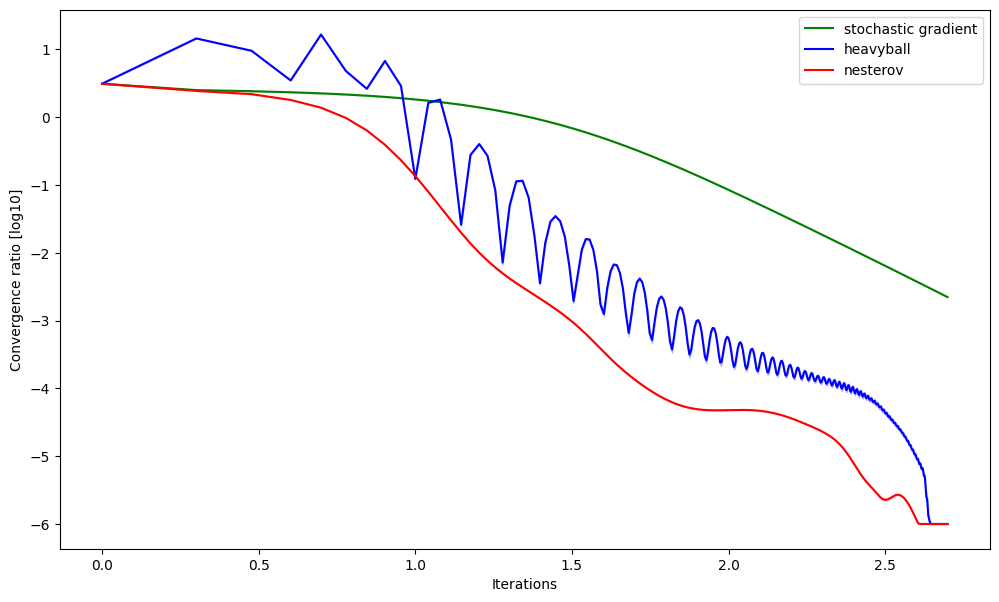

In [24]:
x_ax = np.log10(np.arange(1, 1+_NUM_ITER))

fig, ax = plt.subplots(figsize=(12, 7))

gd_mean = gd_convergence.mean(0)
gd_stderr = gd_convergence.std(0) / np.sqrt(_NUM_EXPERIMENTS)
ax.plot(x_ax, np.log10(gd_mean), '-', c='g', label='stochastic gradient')
ax.fill_between(x_ax, np.log10(gd_mean - gd_stderr), np.log10(gd_mean + gd_stderr), alpha=0.2, color='g')

heavyball_mean = heavyball_convergence.mean(0)
heavyball_stderr = heavyball_convergence.std(0) / np.sqrt(_NUM_EXPERIMENTS)
ax.plot(x_ax, np.log10(heavyball_mean), '-', c='b', label='heavyball')
ax.fill_between(x_ax, np.log10(heavyball_mean - heavyball_stderr), np.log10(heavyball_mean + heavyball_stderr),
                alpha=0.2, color='b')

nesterov_mean = nesterov_convergence.mean(0)
nesterov_stderr = nesterov_convergence.std(0) / np.sqrt(_NUM_EXPERIMENTS)
ax.plot(x_ax, np.log10(nesterov_mean), '-', c='r', label='nesterov')
ax.fill_between(x_ax, np.log10(nesterov_mean - nesterov_stderr), np.log10(nesterov_mean + nesterov_stderr),
                alpha=0.2, color='r')

plt.legend()
ax.set_ylabel('Convergence ratio [log10]')
ax.set_xlabel('Iterations')

plt.show()

Nesterov and heavyball both achieve approximately the same level of accuracy on average but nesterov requires fewer iterations (and the converage ratio oscillates less, which may or may not be significant). So in this case, I'd probably want to go with GD + Nesterov momentum.